## <font color= darkblue> Modelos Estadísticos para el Análisis de la Dirección Diaria del Bitcoin</font>
###### <font color= green> "Finance is not a plug-and-play subject as it relates to machine learning. Modelling financial series is harder than driving cars or recognizing faces." (Marcos Lopez de Prado)</font>
\author{Agustin Muñoz Gonzalez} \date{Julio 2021}

\maketitle
\makeatletter
\renewcommand{\@seccntformat}[1]{}
\makeatother

En este proyecto analizaremos la aplicación y performance de distintos modelos, clásicos y no tan clásicos, al problema de la clasifiación del movimiento diario del Bitcoin. Es decir, la variable respuesta será una variable categórica binaria: $+1$ si el precio de cierre del próximo día es mayor al último cierre y $-1$ en caso contrario.

Si bien el BTC (Bitcoin) ha sido desarrollado hace varias años ya, recientemente ha captado la atención tanto de los inversores institucionalistas como de los retailers. Debido a que todavía es una tecnología novedosa incluso entre los expertos no está del todo claro qué factores afectan su movimiento. Es por eso que las variables explicativas (features) que consideremos intentarán cubrir aspectos ligados a factores que pueden ser relevantes, los mismos son:

\begin{itemize}
\item Precio del BTC;
\item El proceso de ''price discovery'' del BTC (nuevos highs y lows);
\item ''Market sentiment'': indicadores típicos que hacen las veces de un termómetro y narrativa del mercado;
\item Indicadores técnicos;
\item Métricas ''On-chain'': Métricas típicas de la Blockchain.
\end{itemize}

La bibliografía utilizada y pertinente será mencionada al final.

# <font color= darkblue> Parte I: Análisis Exploratorio de Datos \& Ingeniería de los Features</font>


### <font color= darkblue> Obtención de datos, preprocesado de los mismos y definición de los features</font>

Una serie temporal es una serie de datos indexados temporalmente. En general, una serie temporal es una secuencia de observaciones obtenidas en intervalos de tiempo regulados y fijos, y donde la frecuencia de las observaciones puede ser en segundos, minutos, horas, diaria, mensual, trimestral y anual. Los datos del precio de cierre diario del BTC es un ejemplo de serie temporal diaria.

El primer paso hacia cualquier análisis de datos es obtener los datos ''crudos'', y en general involucra obtenerlos desde una fuente y limpiar/completar los datos faltantes. A pesar que los datos vienen en muchas formas, Python posee librerías que facilitan mucho su manejo, por ejemplo Pandas.

### <font color= darkblue>Importando librerías necesarias</font>
Inicialmente importamos varias librerías y paquetes de Python que usaremos a lo largo del trabajo, los mismos cubrirán aspectos sobre visualización, exploración y análisis de datos, como también visualización de resultados. Además, importaremos varios modulos de subpaquetes de Keras necesarios para la creación de los modelos y la medición de la performance de los mismos.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import investpy
# Import preprocessor from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Import from keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Dense, LSTM

# Import cufflinks for visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =(20,10)
plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# We set a seed value in order to be able of reproduce the results.
seed_value= 123
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.set_random_seed(seed_value)

from numpy.random import seed
seed(123)

#### <font color= darkblue> Recolección de datos</font>
El trabajo se basa en datos de los sitios Bitsamp (via quand.com), Investing.com y docs.coinmetrics.io. Si bien en un principio consideraremos datos históricos de BTC desde el COMPLETAR, cuando limpiemos por datos faltantes y armemos el dataframe con todas las features, terminaremos usando datos históricos con frecuancia diaria desde el 23 de Febrero del 2017 hasta el 15 de Marzo de 2021, es decir, alrededor de 1000 datos.

In [12]:
Bitcoin=pd.read_csv('~/Escritorio/Final Data Science/data/BITSTAMP-USD.csv', index_col=0, parse_dates=True).dropna()
Bitcoin = Bitcoin[::-1]

#### <font color= darkblue>Visualización de la fluctuación del BTC</font>

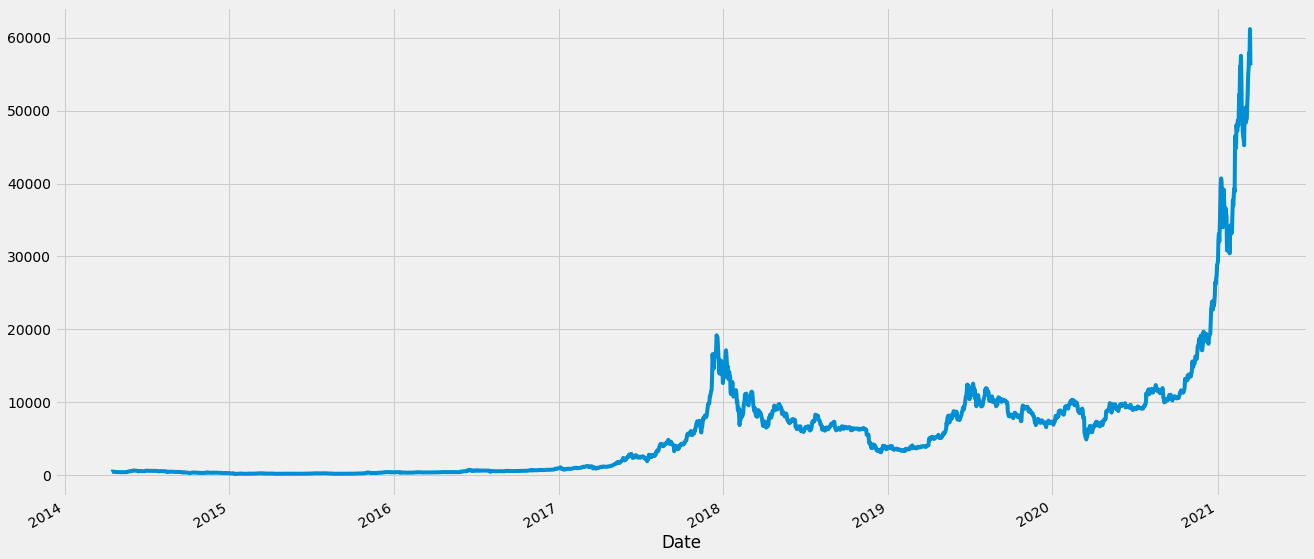

In [13]:
Bitcoin['Last'].plot(figsize=(20,10));

Repitiendo los aspectos que cubrirán los features que consideraremos pero precisando un poco más, consideramos los siguentes aspectos del BTC (y del mercado en general):

\begin{itemize}
\item Factores ligados directamente al precio ''spot'' del BTC y al proceso de price discovery tales como: precios diarios de futuros del BTC y precios diarios de Ethereum;
\item Indicadores macro: algunos commodities importantes como el precio diario del crudo, el tesoro a 10 años de Estados Unidos y el índice de volatilidad de los mercados, VIX;
\item Indicadores técnicos ligados al volúmen, momentum, volatilidad y datos de velas diarias de BTC;
\item Metricas on-chain, i.e., métricas relacionadas pura y exclusivamente con la Blockchain.
\end{itemize}

#### <font color= darkblue> Features</font>
<table>
<thead><tr>
<th style="text-align:left">Symbol</th>
<th style="text-align:left">Description</th>   
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:left">CME_BitcoinFutures</td>
<td style="text-align:left">BTC's future contracts </td>   
</tr>    
<tr>    
<td style="text-align:left">ETH</td> 
<td style="text-align:left">Ethereum's closing price</td>    
</tr>      
<tr>     
<td style="text-align:left">CRUDE, Gold, Treasury_10</td>
<td style="text-align:left">Crude and Gold's futures, and 10 Years Treasury's closing price</td>     
</tr>    
<tr>       
<td style="text-align:left">SPY</td>
<td style="text-align:left">S\& P index's futures</td>       
</tr>    
<tr>      
<td style="text-align:left">ATR</td>
<td style="text-align:left">Average True Range (ATR): a BTC's volatility technnical indicator</td>       
</tr>    
<tr>     
<td style="text-align:left">OBV</td>
<td style="text-align:left">On-balance volume (OBV): a BTC's momentum technnical indicator that uses BTC's daily volume</td>     
</tr>    
<tr>       
<td style="text-align:left">sma14, sma60</td>
<td style="text-align:left">14 and 60 days BTC's moving averages</td>       
</tr>        
<tr>    
<td style="text-align:left">vol14, vol60</td>
<td style="text-align:left">14 and 60 days BTC's volatility</td>    
</tr>       
<tr>    
<td style="text-align:left">sma20,b_upper,b_lower</td>
<td style="text-align:left">BTC's Bollinger Bands: a technnical indicator associated with overbought and oversold</td>      
</tr>    
<tr>         
<td style="text-align:left">MOM5D, STD21</td>
<td style="text-align:left">5-days BTC's momentum, and 21-days BTC's standard deviation with respect to BTC's closing prices and BTC's daily returns, respectly</td> 
</tr> 
<tr>    
<td style="text-align:left">High, Low, Last, Bid, Ask </td>
<td style="text-align:left"> BTC's candlestick data</td>   
</tr>
<tr>     
<td style="text-align:left">Returns </td>
<td style="text-align:left"> BTC's daily returns</td>    
</tr>
<tr>     
<td style="text-align:left">MVRV_FF</td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>     
<td style="text-align:left">HashRate </td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>     
<td style="text-align:left">Miner_revenue </td>
<td style="text-align:left"> COMPLETAR</td>    
</tr>
<tr>    
</tbody>
</table>     


Definimos las funciones que usaremos para el cálculo de algunas de las features anteriores.

In [14]:
def ATR(df,n):
    "function to calculate True Range and Average True Range"
    df = df.copy() # we assume that df's order is increasing in dates

    df['H-L']  = abs(df['High']-df['Low'])
    df['H-PO'] = abs(df['High']-df['Open'].shift(1))
    df['L-PO'] = abs(df['Low']-df['Open'].shift(1))
    
    df['TR']   = df[['H-L','H-PO','L-PO']].max(axis=1,skipna=False)
    df['ATR']  = df['TR'].rolling(n).mean()

    df2 = df.drop(['H-L','H-PO','L-PO'],axis=1)
    return df2

def OBV(df):
	n=len(df)
	OBV=[]
	OBV.append(0)
	for i in range(0,n-1):
		if df['Price'][i]<df['Price'][i+1]:
			OBV.append(OBV[i]+df['Volume'][i+1])
		elif df['Price'][i]>df['Price'][i+1]:
			OBV.append(OBV[i]-df['Volume'][i+1])
	return OBV

# 'CME_BitcoinFutures' and 'ETH' data is expressed as string, so we have to convert it to float.
def text_currency_to_float(text):
  t = text
  dot_pos = t.rfind('.')
  comma_pos = t.rfind(',')
  if comma_pos > dot_pos:
    t = t.replace(".", "")
    t = t.replace(",", ".")
  else:
    t = t.replace(",", "")

  return(float(t))

Cargamos los demás datos necesarios.

In [15]:
#DXY
DXY=pd.read_csv('~/Escritorio/Final Data Science/data/US Dollar Index Historical Data.csv', index_col=0, parse_dates=True).dropna()
DXY=DXY.rename(columns={'Price':'Close'})

# Delete data rows with nan values
DXY=DXY.dropna() 
DXY=DXY[::-1] # We let it ordered decresently

# Otras
EUR_JPY=pd.read_csv('~/Escritorio/Final Data Science/data/EUR_JPY Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
GBP_CAD=pd.read_csv('~/Escritorio/Final Data Science/data/GBP_CAD Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
AUD_CHF=pd.read_csv('~/Escritorio/Final Data Science/data/AUD_CHF Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
CRUDE=pd.read_csv('~/Escritorio/Final Data Science/data/Crude Oil WTI Futures Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Treasury_10=pd.read_csv('~/Escritorio/Final Data Science/data/United States 10-Year Bond Yield Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
SPY=pd.read_csv('~/Escritorio/Final Data Science/data/SPY Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']

# GOLD
Gold=pd.read_csv('~/Escritorio/Final Data Science/data/Gold Futures Historical Data.csv', index_col=0, parse_dates=True, thousands=',')['Price'].dropna()
Gold=Gold[::-1]

Procedemos a armar el dataframe con todos las features y la muestra de datos por un lado, y un dataframe con la variable respuesta correspondiente por otro.

In [16]:
# BTC's returns
rt_Bitcoin=np.around(Bitcoin['Last'].pct_change().dropna(),3)#.reindex(index=rt_BBAR.index[::-1])
# We suit dimensions
Bitcoin=Bitcoin.rename(columns={'Last':'Open'}) # ATR uses 'Open' so we have to rename 'Last'
ATR_Bitcoin = ATR(Bitcoin,21)['ATR']
Bitcoin=Bitcoin.rename(columns={'Open':'Last'}) # We change it to 'Last' again
Bitcoin['Returns']=rt_Bitcoin
Bitcoin['ATR']=ATR_Bitcoin
Bitcoin['OBV']=OBV(Bitcoin[::-1].rename(columns={'Last':'Price'}))[::-1] # OBV uses 'Price' so we change it

# BTC's spot price related Indicators
Bitcoin['CME_BitcoinFutures']=pd.read_csv('~/Escritorio/Final Data Science/data/Bitcoin Futures CME Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']
Bitcoin['ETH']=pd.read_csv('~/Escritorio/Final Data Science/data/Ethereum Historical Data.csv', index_col=0, parse_dates=True).dropna()['Price']

# Macro Indicators
Bitcoin['CRUDE']=CRUDE
Bitcoin['Gold']=Gold
Bitcoin['Treasury_10']=Treasury_10
Bitcoin['SPY']=SPY

# Technnical Indicators
# Simple Moving Averages
# 2 week
Bitcoin['sma14'] = Bitcoin['Last'].rolling(14).mean()
# 2 month
Bitcoin['sma60'] = Bitcoin['Last'].rolling(60).mean()

# Rolling Volatility (annualized assuming 365 trading days)
# 2 week
Bitcoin['vol14'] = Bitcoin['Returns'].rolling(14).std() * np.sqrt(365)
# 2 month
Bitcoin['vol60'] = Bitcoin['Returns'].rolling(60).std() * np.sqrt(365)


# Bollinger Bands
# 20 day simple moving average
Bitcoin['sma20'] = Bitcoin['Last'].rolling(20).mean()
# Upper band
Bitcoin['b_upper'] = Bitcoin['sma20'] + 2 * Bitcoin['sma20'].rolling(20).std()
# Lower band
Bitcoin['b_lower'] = Bitcoin['sma20'] - 2 * Bitcoin['sma20'].rolling(20).std()


MOM5D=np.around([Bitcoin['Last'][t]-Bitcoin['Last'][t-5] for t in range(5,len(Bitcoin['Last']))],3)
STD21D=np.around([np.std(rt_Bitcoin[::-1][t:t+21]) for t in range(0,len(rt_Bitcoin)-21)],3)[::-1]
# For these features we have to reduce the sample size due to min{len(MOM5D),len(STD21D)}<len(Bitcoin)
N=len(STD21D)
Bitcoin=Bitcoin[::-1].iloc[range(0,N)] 
Bitcoin=Bitcoin[::-1] 
Bitcoin['MOM5D']=MOM5D[::-1][0:N][::-1] 
Bitcoin['STD 21D']=STD21D

# On-chain metrics
on_chain_metrics=pd.read_csv('~/Escritorio/Final Data Science/data/btc.csv', index_col=0, parse_dates=True).dropna()
Bitcoin['MVRV_FF']=on_chain_metrics['CapMVRVFF']
Bitcoin['HashRate']=on_chain_metrics['HashRate']
Bitcoin['Miner_revenue']=on_chain_metrics['RevUSD']

# We drop features we won't use
Bitcoin.drop('Volume',axis=1,inplace=True)
Bitcoin.drop('VWAP',axis=1,inplace=True)

# We drop NANs
Bitcoin=Bitcoin.dropna()
Bitcoin=Bitcoin[::-1] # We let it ordered decresently

# We transform string value to float
n_1=len(Bitcoin['CME_BitcoinFutures'])
n_2=len(Bitcoin['ETH'])
for i in range(0,n_1):
	Bitcoin['CME_BitcoinFutures'][i]=text_currency_to_float(Bitcoin['CME_BitcoinFutures'][i])
for i in range(0,n_2):
	Bitcoin['ETH'][i]=text_currency_to_float(Bitcoin['ETH'][i])

In [17]:
X=Bitcoin

In [18]:
list(X.keys())

['High',
 'Low',
 'Last',
 'Bid',
 'Ask',
 'Returns',
 'ATR',
 'OBV',
 'CME_BitcoinFutures',
 'ETH',
 'CRUDE',
 'Gold',
 'Treasury_10',
 'SPY',
 'sma14',
 'sma60',
 'vol14',
 'vol60',
 'sma20',
 'b_upper',
 'b_lower',
 'MOM5D',
 'STD 21D',
 'MVRV_FF',
 'HashRate',
 'Miner_revenue']

In [19]:
# Our response feature will be the sign of BTC's returns (i.e. movement direction)
Y=pd.DataFrame({
	'Sign': np.sign(X['Returns'])})
# We transform 0's into 1's in order to work with a binary classification problem
for i in range(len(Y['Sign'])):
	if Y['Sign'][i]==0:
		Y['Sign'][i]=1

In [20]:
X.head(), Y.head()

(                High       Low      Last       Bid       Ask  Returns  \
 Date                                                                    
 2021-03-15  60748.78  54555.00  56196.91  56174.41  56188.70   -0.081   
 2021-03-12  58155.99  54269.00  57881.67  57847.33  57877.59    0.036   
 2021-03-11  57402.89  53010.00  55853.90  55914.60  55920.20    0.017   
 2021-03-10  54939.26  51857.00  54927.29  54901.04  54927.49    0.048   
 2021-03-09  52427.91  49316.98  52427.91  52432.31  52439.00    0.028   
 
                     ATR          OBV CME_BitcoinFutures      ETH  ...  \
 Date                                                              ...   
 2021-03-15  4530.447619     0.000000              56900  1792.38  ...   
 2021-03-12  4375.560000  7593.458385              57075   1766.9  ...   
 2021-03-11  4271.292381   674.097023              57955  1825.79  ...   
 2021-03-10  4240.383810 -4753.680697              56620  1794.14  ...   
 2021-03-09  4263.443333 -9174.22751

In [21]:
# We escalate the data in order to perform the feature selection methods
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)


# We let X as a dataframe
X=pd.DataFrame(scaled_X,columns=list(Bitcoin.keys()))  

## Selección de Features

Los métodos de selección de features intentan reducir el número de features considerados de forma de quedarnos sólo con los que son más ''útiles'' para el modelo.

Es menester hacer una distinción entre el tipo de análisis que estemos persiguiendo, diferenciando entre: un análisis descriptivo, un análisis predictivo o un análisis explicativo.

El análisis o paradigma descriptivo involucra una simple mención de los hechos tal y como son. Este análisis no provee conclusiones ni generalizaciones sino que pretende brindar una idea amplia del problema a tratar y brindar un resumen o estadísticas descriptivas como la media, desviaciones estándares, y algunos gráficos para una mejor visualización de los datos. En general, los método asociados a este paradigma están en el extremo (izquierdo) del eje de complejidad de los modelos, utilizando los más simples y parsimoniosos. Acá lo que importa es el ''qué''.

El paradigma explicativo intenta no sólo describir sino, aún más, interpretar de forma intuitiva la relación entre las variables explicativas y la variable respuesta. Cuando estamos tratando con datos cuantitativos y estadísticos este análisis provee modelos matemáticos que vinculan todas las variables consideradas. Es decir, no se trata ya de describir sino de explicar las relaciones de causalidad entre los fenómenos estudiados. En general, involucran modelos estadísticos que están en el extremo derecho del eje de complejidad, utilizando métodos muy complejos. Podemos pensar que acá estamos buscando el ''por qué''.

El análisis predictivo irá un paso más allá que el explicativo en tanto que utilizará las relaciones descubiertas en los otros paradigmas en datos desconocidos y eventos futuros. Hay que tener en cuenta que este análisis puede no involucrar el mismo modelo ni las mismas features que los análisis previos (en general, las features consideradas acá seran un subgrupo de las consideradas en el paradigma explicativo). Suele involucrar modelos que están en un punto medio en el eje de complejidad, intentando equilibrar el trade-off sesgo/varianza. Este análisis puede pensarse como el ''que tal si''.

A continuación, usaremos dos métodos de selección de features que se suelen usar para el análisis explicativo. Aunque nosotros queramos realizar un análisis predictivo del fenómeno BTC, teniendo en cuenta que este suele quedarse con un subgrupo de las features consideradas en el apporach explicativo, es que parece coherente y útil realizar esta reducción de variables explicativas

#### SelectKBest (para clasificación: f\_classif, )
La clase SelectKBest puntea las features usando una cierta función (en este caso, f\_classif, pero podría ser otra) y luego se queda sólo con las $K$ features con los scores más altos. La función f\_classif es la función ANOVA F-value entre la variable respuesta y las explicativas para un problema de clasificación, donde por ANNOVA F-value entendemos al test ANNOVA referido al test F.

ANOVA es un acrónimo para ''analysis of variance'' (análisis de la varianza) y es un test de hipótesis para determinar si la media de dos o más muestras de datos provienen de la misma distribución.

El estadístico F, o test F, es una clase de test estadístico que calcula el ratio que representa la varianza explicada por el modelo o la varianza explicada por una prueba estadístia como ANOVA.

In [22]:
# feature selection
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# We apply SelectKBest class to order the most relevant features with respect to f_classif
bestfeatures = SelectKBest(score_func=f_classif, k=len(X.keys()))
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
# we concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(len(X.keys()),'Score'))  #print 10 best features

                 Specs       Score
5              Returns  890.526829
21               MOM5D   54.597695
23             MVRV_FF   13.104378
10               CRUDE    1.843723
7                  OBV    1.087757
15               sma60    0.834043
12         Treasury_10    0.791836
22             STD 21D    0.673978
6                  ATR    0.609570
16               vol14    0.592126
19             b_upper    0.434973
18               sma20    0.379058
17               vol60    0.370301
14               sma14    0.339373
20             b_lower    0.303481
24            HashRate    0.282368
3                  Bid    0.245523
2                 Last    0.244707
4                  Ask    0.244136
9                  ETH    0.151103
11                Gold    0.081456
13                 SPY    0.036414
1                  Low    0.009375
8   CME_BitcoinFutures    0.005251
0                 High    0.003658
25       Miner_revenue    0.000112


#### ExtraTreesClassifier
##### Árbol de decisión (Alta Varianza)
Un único árbol de decisión usualmente sobreajusta los datos que intenta aprender debido a que aprende a partir de una sóla ruta de decisiones. Predicciones resultantes de un sólo árbol de decisión usualmente no son precisas en datos out-of-sample.

###### Random Forest (Varianza Media)
Los modelos Random forest reducen el riesgo de overfitting introduciendo aleatoriedad como sigue:
\begin{itemize}
\item construyendo árboles múltiples (n\_estimators);
\item extrayendo observaciones con reposición (i.e., muestras bootstrappeadas);
\item dividiendo los nodos en los mejores splits dentro de subconjuntos de features elejidos aleatoriamente en cada nodo.
\end{itemize}

##### Extremely Randomized Trees (or Extra Trees for short)
Es un modelo de ensemble learning.

Específicamente, es el ensamblado de árboles de decisión y está relacionado a otros ensamblados de árboles de decisión tales como bagging y random forest.

Esta clase implementa un estimador que fitea un número de árboles de decision aleatorizados (a.k.a. extra-trees) en varias sub-muestras del dataset y luego promedia para mejorar la precisión predictiva y controlar el overfitting. Árboles de decisión baggeados tales como extra-trees pueden ser usados para estimar la importancia de las features.

[0.02341745 0.02250477 0.0228883  0.02325348 0.02365027 0.39849194
 0.02086329 0.02878642 0.01937727 0.02174591 0.02313906 0.02314735
 0.02465235 0.02141748 0.02071107 0.01932197 0.02419679 0.02114105
 0.01950027 0.02111682 0.02084231 0.050332   0.02539447 0.02658352
 0.02672452 0.02679987]


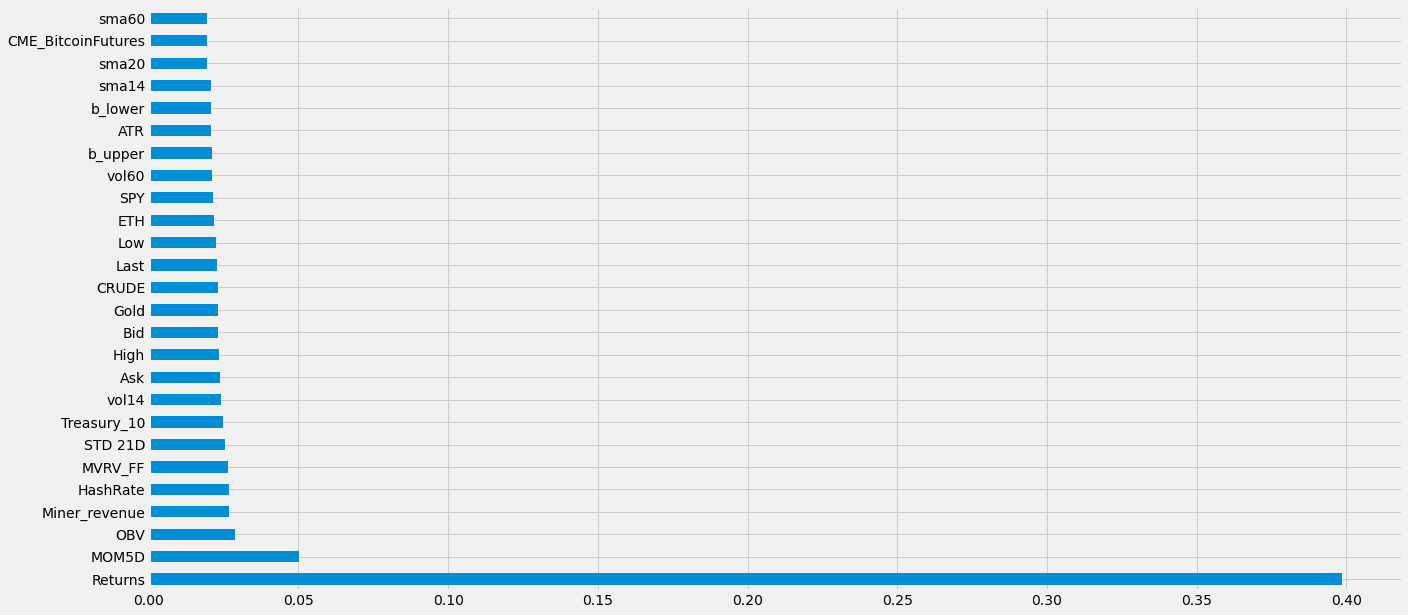

In [23]:
# FEATURE IMPORTANCE
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,Y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.keys())).plot(kind='barh')
plt.show()

#### PCA probabilístico y Factor Analysis (FA)

PCA probabilístico y Factor Analysis son modelos probabilísticos que usan la verosimilitud de los datos para la selección del features. Acá compararemos PCA y FA usando validación cruzada.

best n_components by PCA CV = 0
best n_components by FactorAnalysis CV = 5
best n_components by PCA MLE = 25


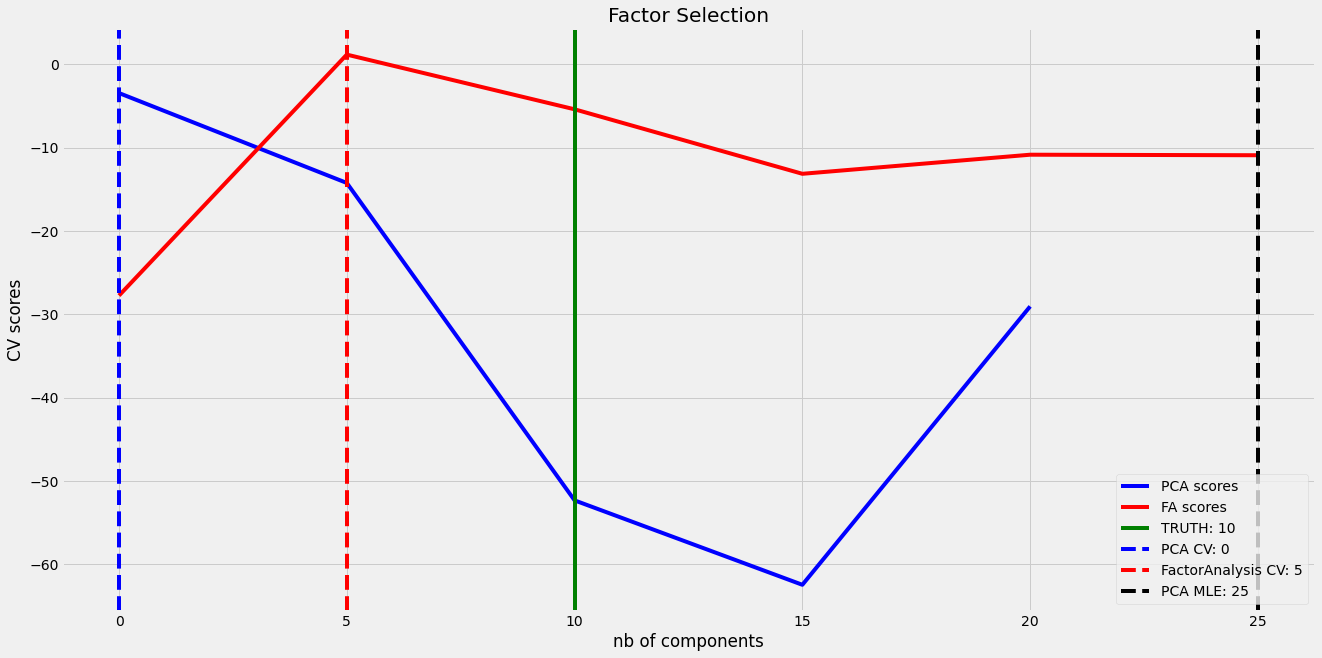

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, FactorAnalysis
n_samples, n_features, rank = len(X), len(list(X.keys())), 10
n_components = np.arange(0, len(list(X.keys())), 5)
def compute_scores(X):
    pca = PCA(svd_solver='full')
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores
pca_scores, fa_scores = compute_scores(X)
n_components_pca = n_components[np.argmax(pca_scores)]
n_components_fa = n_components[np.argmax(fa_scores)]
pca = PCA(svd_solver='full', n_components='mle')
pca.fit(X)
n_components_pca_mle = pca.n_components_

print("best n_components by PCA CV = %d" % n_components_pca)
print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
print("best n_components by PCA MLE = %d" % n_components_pca_mle)

plt.figure()
plt.plot(n_components, pca_scores, 'b', label='PCA scores')
plt.plot(n_components, fa_scores, 'r', label='FA scores')
plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
plt.axvline(n_components_fa, color='r',
                label='FactorAnalysis CV: %d' % n_components_fa,
                linestyle='--')
plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('Factor Selection')
plt.show()

In [25]:
fa_scores, pca_scores
n_components

array([ 0,  5, 10, 15, 20, 25])

In [26]:
X_=pca.fit_transform(X)
X_

array([[ 2.90265610e+00,  1.18466053e+00, -6.14464447e-01, ...,
        -2.54498288e-03, -1.51934076e-04, -2.56177338e-04],
       [ 2.89846241e+00,  1.15793677e+00, -6.55723470e-01, ...,
         3.12052528e-03, -2.95347142e-04,  7.22165953e-06],
       [ 2.81857117e+00,  1.16371879e+00, -6.04243377e-01, ...,
         2.11282268e-02,  8.91229658e-04,  4.43837177e-05],
       ...,
       [-9.02204028e-01,  8.39876024e-03, -2.75985978e-02, ...,
        -4.60442110e-05, -5.47486124e-08,  7.43501528e-06],
       [-8.93254461e-01, -6.47722603e-03, -2.38402366e-02, ...,
         5.20736855e-04, -2.51462052e-05,  8.82993408e-06],
       [-9.05936039e-01,  1.31268435e-02, -2.93642661e-02, ...,
        -2.04861525e-04,  2.11818285e-05,  6.13491854e-06]])

In [27]:
Y_=pd.DataFrame(X_)
Y_

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2.902656,1.184661,-0.614464,0.152279,0.133946,-0.168140,0.301636,0.037621,-0.084731,-0.036684,...,-0.047969,0.072464,-0.060541,0.115940,0.060039,0.000505,0.032031,-0.002545,-1.519341e-04,-0.000256
1,2.898462,1.157937,-0.655723,0.245999,0.119036,0.088334,0.175559,0.325205,-0.248135,-0.094072,...,0.080259,0.092358,-0.007232,0.047166,-0.000265,-0.001208,-0.016542,0.003121,-2.953471e-04,0.000007
2,2.818571,1.163719,-0.604243,0.262137,0.131327,-0.000675,0.163465,0.264329,-0.183846,-0.080873,...,0.030584,0.076325,-0.042794,0.015362,-0.008853,-0.001814,-0.003571,0.021128,8.912297e-04,0.000044
3,2.820162,1.126800,-0.571852,0.220294,0.116911,0.044538,0.173805,0.286361,-0.141795,-0.042445,...,0.036532,0.086444,-0.025142,0.003341,-0.022471,-0.008842,-0.021517,0.016216,-1.987358e-04,0.000006
4,2.723447,1.125170,-0.528034,0.176976,0.127545,-0.089200,0.189779,0.174382,0.016226,0.028307,...,-0.021971,0.067656,-0.043306,0.000684,-0.011183,-0.006823,-0.031152,0.023785,1.512582e-04,-0.000164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,-0.908212,0.024660,-0.049445,0.500035,0.083379,-0.124489,0.077708,0.051709,0.008129,-0.060200,...,0.007643,-0.011603,-0.014145,-0.004102,0.007678,-0.000168,-0.000485,-0.000348,2.594697e-05,0.000011
994,-0.906525,0.012448,-0.037607,0.497136,0.090466,-0.114294,0.080037,0.081274,0.016688,-0.039683,...,0.001469,-0.014721,-0.011181,-0.002911,0.006268,-0.000579,0.000452,-0.000256,1.631851e-05,-0.000008
995,-0.902204,0.008399,-0.027599,0.504727,0.085320,-0.107554,0.071271,0.096926,0.031321,-0.037085,...,-0.001565,-0.014589,-0.011150,-0.002950,0.006643,-0.000556,0.001225,-0.000046,-5.474861e-08,0.000007
996,-0.893254,-0.006477,-0.023840,0.508675,0.096322,-0.072680,0.063398,0.129201,0.056686,-0.028496,...,-0.007610,-0.014512,-0.010388,-0.003487,0.005931,-0.000684,0.003038,0.000521,-2.514621e-05,0.000009


In [28]:
X

,High,Low,Last,Bid,Ask,Returns,ATR,OBV,CME_BitcoinFutures,ETH,...,vol14,vol60,sma20,b_upper,b_lower,MOM5D,STD 21D,MVRV_FF,HashRate,Miner_revenue
0,1.000000,0.982002,0.970420,0.970610,0.970344,0.366795,1.000000,0.987792,0.981513,0.915979,...,0.399087,0.630384,1.000000,0.892641,1.000000,0.550266,0.518519,0.631542,0.900243,0.932720
1,0.956582,0.976766,1.000000,1.000000,1.000000,0.592664,0.965546,0.992416,0.984580,0.902861,...,0.301618,0.644549,0.992983,0.908815,0.966071,0.969812,0.481481,0.662347,0.912653,0.968008
2,0.943971,0.953714,0.964397,0.966046,0.965630,0.555985,0.942352,0.988202,1.000000,0.933178,...,0.339663,0.652203,0.991131,0.919178,0.949806,0.865844,0.481481,0.676488,0.800966,0.865257
3,0.902715,0.932604,0.948128,0.948239,0.948198,0.615830,0.935476,0.984897,0.976606,0.916885,...,0.339663,0.652736,0.986928,0.928363,0.930087,0.838613,0.506173,0.660014,0.906448,0.934387
4,0.860661,0.886098,0.904246,0.904868,0.904502,0.577220,0.940606,0.982205,0.943312,0.955474,...,0.413804,0.649579,0.984199,0.938601,0.912155,0.592185,0.493827,0.645159,0.850605,0.856911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0.002981,0.004674,0.004629,0.004632,0.004630,0.515444,0.003043,0.000000,0.000578,0.002224,...,0.138124,0.372538,0.000898,0.000887,0.001397,0.481275,0.209877,0.447226,0.000294,0.009336
994,0.002780,0.004541,0.004721,0.004718,0.004693,0.546332,0.003057,0.002826,0.000578,0.001416,...,0.132953,0.373178,0.000759,0.000730,0.001298,0.484687,0.209877,0.430302,0.001442,0.010073
995,0.002562,0.003882,0.004476,0.004446,0.004448,0.571429,0.003034,0.000670,0.000578,0.001230,...,0.136592,0.373404,0.000616,0.000575,0.001188,0.484222,0.209877,0.434606,0.000294,0.007532
996,0.002711,0.003657,0.004590,0.004525,0.004537,0.621622,0.001627,0.015962,0.000578,0.000000,...,0.111019,0.380178,0.000172,0.000139,0.000791,0.488289,0.209877,0.434044,0.002717,0.012405


Nos quedamos con $n=5$ de las mejores features según los métodos anteriores.

In [29]:
best_feat=list(feat_importances.nlargest(5).keys())
for i in list(feat_importances.keys()):
	if(i not in best_feat):
		X.drop(i,axis=1,inplace=True)

#### Matriz de correlación
La correlación (de Pearson) es una medida de dependencia lineal entre dos variables aleatorias cuantitativas. De manera menos formal, podemos definir el coeficiente de correlación de Pearson como un ı́ndice que puede utilizarse para medir el grado de relación de dos variables siempre y cuando ambas sean cuantitativas y continuas. En este caso, analizaremos la correlación entre las features de nuestro dataset. El objetivo será quedarnos con features que no estén (demasiado) correlacionadas, de modo que ofrezcan distinta información.

Veamos como nos queda la matriz de correlaciones entre las features que quedaron.

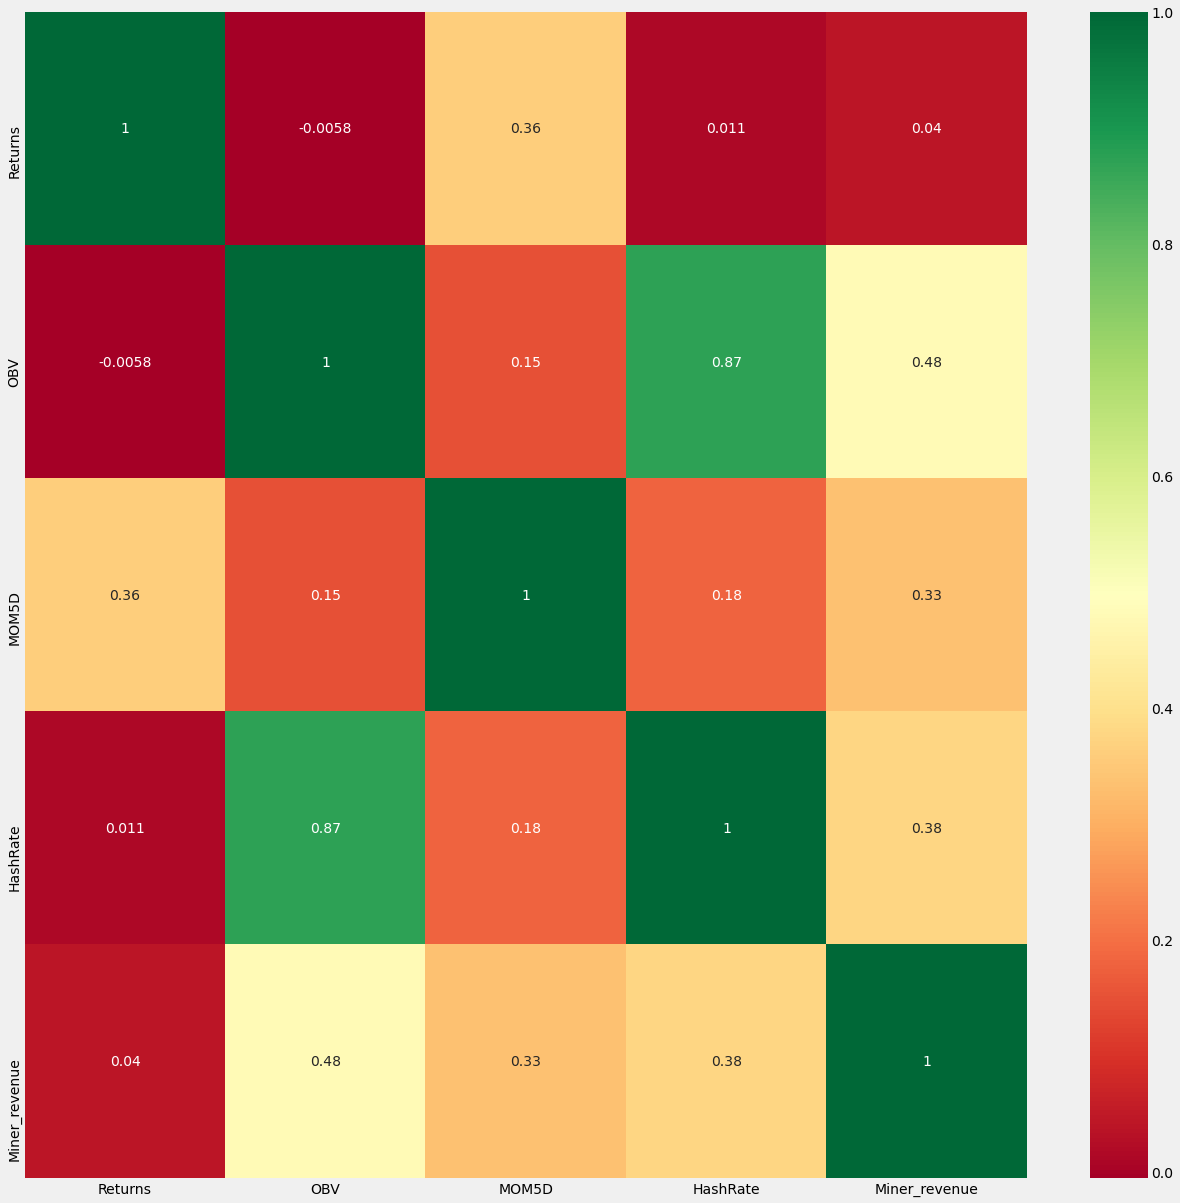

In [30]:
# Correlation Matrix with Heatmap
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

Se puede ver que hay baja correlación entre casi todas las features

### <font color= darkblue> Normalizado del dataset
El escalamiento de los features puede ayudar a los algoritmos a converger a minimos locales/globales eficientemente. Además, puede pasar que las medidas utilizadas en las features varien mucho en magnitud de una a otra pudiendo ''confundir'' al modelo, interpretando este que una feature es más relevante que las demás sólo por el hecho de utilizar números más grandes. Por ejemplo, si uno no normaliza podría suceder que en el proceso de actualización de los pesos en las redes neuronales por medio del método de descenso de gradiente, la actualización genere pasos demasiado grandes evitando que el método converja.

Usaremos el escalador MinMaxScaler de la librería Sci-kit Learn. https://scikitlearn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

#### <font color= darkblue>Split de los datos</font>
Una parte critica del machine learning es tener una clara distinción entre los datos que se usarán para entrenar el modelo y los que se usarán para evaluar el poder predictivo del mismo. Por lo tanto, usaremos el clasico Train/Test split, con un Train set del 70\% de los datos.

Algunos de los métodos de machine learning que usaremos también permiten especificar si queremos considerar un Validation Set en el entrenamiento del modelo.

In [31]:
# 70% train/test split
split = int(len(X) * 0.7)

# We transform Y to a binary classification problem's values (0 y 1)
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder() 
encoder.fit(Y) 
encoded_Y = encoder.transform(Y) 
# We transform encoded_Y into a dataframe in order to use .iloc and being able to make the train/test split
Y = pd.DataFrame(encoded_Y, columns = ['Column_A']) 

# Create train data set
X_train, y_train = X.iloc[split:], Y.iloc[split:]
# Test data after train split
X_test, y_test = X.iloc[:split], Y.iloc[:split]


# Scale the features MinMax for training and test datasets
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
#
X_train=scaled_X_train
X_test=scaled_X_test

#### Reacomodamiento de los datos
Para la red neuronal LSTM necesitamos cambiar el formato de los datos dado que la red consume datos en 3 dimensiones de la forma: cantidad de datos, cantidad de time-steps y cantidad de features. 

In [32]:
# Reshaping the Data for LSTM and ALSTM
# reshaping into 3D Array
X_train_LSTM=np.array(scaled_X_train).reshape(len(scaled_X_train),1,len(list(X.keys()))) # len(scaled_train_data) samples; 1 timesteps per sample; 9 features per timestep or 1 samples; len(scaled_train_data) timesteps; 9 features per timestep?
X_test_LSTM=np.array(scaled_X_test).reshape(len(scaled_X_test),1,len(list(X.keys())))

# check whether the next lines are neccesary
# y_train=np.array(y_train)
# y_test=np.array(y_test)

# <font color= darkblue> Parte II:  Construcción de los modelos</font> 

#### <font color= darkblue>Keras </font>
Keras es una API de Python y es una de las librerías mas poderosas y amigables para el usuario que está basada, a su vez, en la popular librería TensorFlow para la creación de modelos de machine learning y deep learning. 

In [33]:
import numpy as np
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model

### 1. Naive Bayes
El método de Naive Bayes es un algoritmo de aprendizaje supervisado basado en la aplicación del teorema de bayes con la asunción ''naive'' o inocente de independencia condicional entre pares de features dado el valor de la clase de la variable respuesta.

In [34]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB().fit(X_train, y_train)
print("score on test: " + str(mnb.score(X_test, y_test)))
print("score on train: "+ str(mnb.score(X_train, y_train)))

score on test: 0.49140401146131807
score on train: 0.6533333333333333


### 2. Logistic Regression
Logistic regression es un modelo estadístico que en su forma básica usa una función logística para modelar una variable respuesta binaria. En este modelo, el logaritmo de la probabilidad (log-odds) para el valor ''+1'' es una combnación lineal de los predictores. La función que convierte el logaritmo de la probabilidad en una probabilidad se llama función logística, de ahí el nombre. La unidad de medida de la escala de las log-odds se llama logit (logistic unit).

In [35]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("score on test: " + str(lr.score(X_test, y_test)))
print("score on train: "+ str(lr.score(X_train, y_train)))

score on test: 0.6289398280802292
score on train: 0.8833333333333333


### 3. K-Nearest Neighbours
El método de clasificación k-NN es un métedo que se basa en clasificar según la pluralidad de los votos de los $K$ vecinos ''mas cercanos'' del punto de la muestra que queremos clasificar y para una cierta noción de distancia. Por ejemplo, si $K=1$ el objeto se clasificará como la clase de su vecino más próximo.

Como este algoritmo se basa en una distancia, si las features están representadas en distintas unidades o en escalas muy diferentes, la normalización de los datos puede mejorar dramáticamente la perfomance del método.

Una peculiaridad del algotimo K-NN es su sensibilidad a la estructura local de los datos.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(X_train, y_train)
print("train shape: " + str(X_train.shape))
print("score on test: " + str(knn.score(X_test, y_test)))
print("score on train: "+ str(knn.score(X_train, y_train)))

train shape: (300, 5)
score on test: 0.501432664756447
score on train: 0.9333333333333333


### 4. Support Vector Machine (SVM)
SVM es un método de clasificación binaria que interpreta los datos como puntos en un espacio $p$-dimensional, con $p$ la cantidad de features consideradas, y lo que busca es separarlos por medio de un hiperplano, es decir, por medio de un subespacio del espacio ambiente de dimensión $p-1$. Como en general hay infinitos hiperplanos que separan los datos una buena elección es el que presenta la mayor separación, o márgen, entre las dos clases. ES decir, se elije el hiperplano que maximiza la distancia de este al punto más cercano de la muestra.

In [37]:
from sklearn.svm import LinearSVC
svm=LinearSVC(C=100)
svm.fit(X_train, y_train)
print("score on test: " + str(svm.score(X_test, y_test)))
print("score on train: "+ str(svm.score(X_train, y_train)))

score on test: 0.839541547277937
score on train: 0.98


### 5. Decision Tree
Algo ya mencionamos al respecto pero podemos decir que un árbol de decisión es una estructura formada por nodos, ramas y hojas, en el que cada nodo representa una prueba sobre un atributo (por ej. que $X_1>58$), cada rama representa el resultado de la prueba y cada hoja representa la etiqueta o clase para el dato considerado. El camino desde la raíz hasta las hojas representa reglas de clasificación.

El árbol de decisión puede ser linealizado a reglas de decisión, donde el resultado es el contenido de las hojas, y las condiciones a lo largo de cada camino forma una conjunción en la forma de clausulas if. En general, las reglas tienen la forma siguiente:

if condition1 and condition2 and condition3 then outcome.

Es decir, un árbol de decisión es un método de aprendizaje superviasado y no paramétrico usado para clasificación y regresión cuyo objetivo es crear un modelo que prediga el valor de la variable respuesta a fuerza de aprender simples reglas de decisión (if-else) inferidas de las features.

In [38]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print("score on test: "  + str(clf.score(X_test, y_test)))
print("score on train: " + str(clf.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


Aplicar un único árbol de decisión a un dataset rico en features puede guiar a un problema de overfitting. De hecho, vemos que una precisión del 100\% significa que el modelo se aprendió de memoria el conjunto de entrenamiento y, por ende, va a generalizar pobremente en el test set. 

Sin embargo, este problema puede evitarse afinando los parámetros del modelo o utilizando una técnica de ensemble learning como Random Forest. Los siguientes métodos muestran ejemplos de esto.

En la bibliografía dejamos un link con un artículo que trata en profundidad el correcto seteo de los parámetros de un clasificador por árbol de decisión: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3.

### 6. Bagging Decision Tree (Ensemble Learning I)
Bagging (Bootstrap aggregating), es un método de ensamblado de machine learning (ensemble learning) diseñado para mejorar la estabilidad y precisión de algoritmos de machine learning usados en clasificación y regresión. Además, reduce la varianza y ayuda a evitar el overfitting.

Cuando un árbol de decisión overfittea, aplicar un algoritmo de ensemble learning como bagging puede mejorar la calidad de predicción del modelo.

En bagging, los datos de entrenamiento se van incrementando tomando muestras bootstrapeadas del train set. Esto significa tomar multiples muestras con reposición del train set y entrenar el modelo con estas submuestras. La predicción final es un promedio tomado sobre todas las predicciones resultante de los modelos entrenados con cada sub muestra bootstrapeada.

In [39]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% taken here all 10K 
# n_estimators: number of decision trees 
bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train, y_train)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


### 7. Boosting Decision Tree (Ensemble Learning II)
En machine learning, boosting es otro método de ensemble learning cuyo principal objetivo es reducir el sesgo de varios modelos simples de forma de obtener un modelo más complejo y poderoso. 

"¿Puede un conjunto de predictores débiles crear un predictor fuerte?" [Kearns and Valiant (1988, 1989)] 

Un predictor débil es un clasificador que es sólo ligeramente mejor que tirar una moneda (random guessing). En contraste, un predictor fuerte es un clasificador que está arbitrariamente mejor correlacionado con la clasificación real.

El algoritmo de boosting consiste en aprender iterativamente predictores débiles con respecto a una distribución y sumarlos en un clasificador final fuerte. Cuando estos algoritmos débiles son sumados, se pesan de forma que esté relacionada con su precisión. Luego de que un predictor débil es sumado, los pesos se actualizan para que datos mal clasificados tengan mucho peso y datos clasificados correctamente tengan poco peso. Así, los próximos predictores débiles se concentrarán en los ejemplos previamente mal clasificados.

En general, no podemso usar Boosting para mejorar un modelo completamente overfitteado con precisión del 100\%. Para apicar este método a nuestro árbol de decisión anterior, tenemos que torcerlo un poco.

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
adb = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,max_depth=4),n_estimators=10,learning_rate=0.6)
adb.fit(X_train, y_train)
print("score on test: " + str(adb.score(X_test, y_test)))
print("score on train: "+ str(adb.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


### 8. Random Forest (Ensemble Learning III)
Random forests o random decision forests es un método de ensamble learning utilizado tanto para regresión como para clasificación, que opera construyendo múltiples árboles de decisión en cada paso de entrenamiento. Para tareas de clasificación, la salida será la clase seleccionada por la mayoría de los árboles (regla de la mayoría).

i.e. el clasificador Random Forest es básicamente un algoritmo de bagging aplicado a árboles de decisión que selecciona los subconjuntos de forma distinta a la clásica. Hemos notado que max\_depth=9 es un buen valor para este dataset.

In [41]:
from sklearn.ensemble import RandomForestClassifier
# n_estimators = number of decision trees
rf = RandomForestClassifier(n_estimators=30, max_depth=9)
rf.fit(X_train, y_train)
print("score on test: " + str(rf.score(X_test, y_test)))
print("score on train: "+ str(rf.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


### 9. Voting Classifier (Ensemble Learning IV)
Este clasificador de nuestra caja de ensemble learnings evalúa distintos clasificadores y toma la mejor decisión a partir de la regla de la mayoría.

La idea detrás del VotingClassifier es combinar clasificadores de machine learning conceptualmente distintos y usar la regla de la mayoría o el promedio de las probabilidades predichas, para predecir la nueva clase. Este clasificador es útil si se utiliza con un conjunto de modelos con buena performance dado que equilibra y supera las debilidades individuales.

Usaremos este método para combinar los siguientes modelos anteriores:

\begin{itemize}
\item Naive Bayes (84\%, 2s);
\item Logistic Regression (86\%, 60s, overfitting);
\item Random Forest (80\%, 20s);
\item Support Vector Machine (85\%, 10s).
\end{itemize}

In [42]:
from sklearn.ensemble import VotingClassifier
# 1) naive bias = mnb
# 2) logistic regression =lr
# 3) random forest =rf
# 4) support vector machine = svm
evc=VotingClassifier(estimators=[('mnb',mnb),('lr',lr),('rf',rf),('svm',svm)],voting='hard')
evc.fit(X_train, y_train)
print("score on test: " + str(evc.score(X_test, y_test)))
print("score on train: "+ str(evc.score(X_train, y_train)))

score on test: 0.6289398280802292
score on train: 1.0


### 10. PPR
Projection pursuit regression (PPR) es un modelo estadístico desarrollado por Jerome H. Friedman y Werner Stuetzle que es una extensión de los modelos aditivos. El modelo adapta los modelos aditivos de forma que primero proyecta los datos en la dirección óptima (de mayor variabilidad) antes de aplicar funciones suaves a las variables expicativas.

Es decir, el modelo consiste de combinaciones lineales de funciones ridge (funciones no lineales que sólo varían en una dirección).

Dado un conjunto de datos $\{(y_{i},x_{i})\}_{i=1}^{n}\}$, el objetivo es minimizar la función de error

$$\min_{f_{j},\beta_{j}}S=\sum_{i=1}^{n}\left[y_{i}-\sum_{j=1}^{r}f_{j}(\beta_{j}^{\mathrm{T}}x_{i})\right]^{2},$$

sobre las funciones $f_{j}$ y los vectores $\beta_{j}$. 

Pares fiteados previamente pueden ser reajustados luego de que nuevos pares sean determinados por medio de un algoritmo conocido como backfitting, que implica tomar pares previos, recalcular el residuo dado por los demás pares calculados, reajustar para tener en cuenta esa nueva información y luego recorrer todos los pares de ajuste de esta manera hasta que los parámetros converjan.

El modelo PPR model es un aproximador universal, dado que puede aproximar cualquier función continua en $\mathbb{R}^p$.

In [43]:
from skpp import ProjectionPursuitRegressor
from skpp import ProjectionPursuitClassifier
import keras
# r: The number of terms in the underlying additive model. The input will be put through r projections, r functions of those projections, and then multiplication by r output vectors to determine output.
#ppr = ProjectionPursuitRegressor(r=10)
ppr = ProjectionPursuitClassifier(r=10)
fit=ppr.fit(X_train, y_train)
ppr_prediction=ppr.predict(X_test)

In [44]:
import sklearn
ppr_accuracy=sklearn.metrics.accuracy_score(y_test,ppr_prediction)
ppr_cross_entropy_loss=sklearn.metrics.log_loss(y_test, ppr_prediction)
ppr_zero_one_loss=sklearn.metrics.zero_one_loss(y_test,ppr_prediction)
print('MLP: [accuracy, crossentropy loss, zero/one loss] =', [ppr_accuracy,ppr_cross_entropy_loss, ppr_zero_one_loss])

MLP: [accuracy, crossentropy loss, zero/one loss] = [0.6446991404011462, 12.271882616950714, 0.3553008595988538]


### 11. Redes neuronales y Deep Learning
Se asume que el lector está al tanto de las nociones básicas sobre ANNs ya que la intención de este trabajo es mostrar la aplicación y la precisión de distintos modelos de la ciencia de datos y la estadística. Sólo mencionaremos que deep learning se trata redes neuronales que tienen al menos 2 capas ocultas que se utilizan para extraer progresivamente características de nivel superior de los datos de entrenamiento.

Antes que nada, usaremos una red simple de tres capas sin optimización, excepto la utilización de un pequeño validation set.

In [45]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape = (X_train.shape[0],X_train.shape[1])))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
# 0.33 validation dataset
model.fit(X_train,y_train,epochs=4,batch_size=512,validation_split=0.33)
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Epoch 1/4
1/1 [==============================] - 2s 2s/step - loss: 0.6991 - accuracy: 0.5000 - val_loss: 0.6887 - val_accuracy: 0.5900
Epoch 2/4
1/1 [==============================] - 0s 44ms/step - loss: 0.6954 - accuracy: 0.5050 - val_loss: 0.6866 - val_accuracy: 0.6200
Epoch 3/4
1/1 [==============================] - 0s 46ms/step - loss: 0.6930 - accuracy: 0.5100 - val_loss: 0.6850 - val_accuracy: 0.6200
Epoch 4/4
22/22 [==============================] - 0s 1ms/step - loss: 0.6875 - accuracy: 0.5330
score on test: 0.532951295375824
10/10 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5533
score on train: 0.5533333420753479


Usa redes neuronales lleva al mejor performance hasta el momento. Sin embargo, la configuración estándar lleva a un overfitting de los datos.

Este problema puede evitarse fácilmente agregando algunos cambios menores en los parámetros de forma de reducir un poco el puntaje de entrenamiento.

En lo que sigue aplicaremos las siguientes tres metodologías para reducir manualmente el overfitting de una red neuronal:

\begin{itemize}
\item reducir el tamaño de la red;
\item agregar algunos pesos para regularización;
\item agregar dropout.
\end{itemize}

In [46]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import regularizers
from keras import metrics
model=models.Sequential()
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu',input_shape=(X_train.shape[0],X_train.shape[1])))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l2(0.003),activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=4,batch_size=512,validation_split=0.33)
print("score on test: " + str(model.evaluate(X_test,y_test)[1]))
print("score on train: "+ str(model.evaluate(X_train,y_train)[1]))

Epoch 1/4
1/1 [==============================] - 1s 829ms/step - loss: 0.8162 - accuracy: 0.5050 - val_loss: 0.7368 - val_accuracy: 0.5700
Epoch 2/4
1/1 [==============================] - 0s 48ms/step - loss: 0.8075 - accuracy: 0.4950 - val_loss: 0.7374 - val_accuracy: 0.5500
Epoch 3/4
1/1 [==============================] - 0s 63ms/step - loss: 0.8180 - accuracy: 0.5250 - val_loss: 0.7380 - val_accuracy: 0.5300
Epoch 4/4
22/22 [==============================] - 0s 2ms/step - loss: 0.7374 - accuracy: 0.4857
score on test: 0.48567333817481995
10/10 [==============================] - 0s 2ms/step - loss: 0.7387 - accuracy: 0.5367
score on train: 0.5366666913032532


Next, we will use three types of neural networks: MLP (multi-layer perceptron), LSTM and ALSTM.

#### Multilayer Perceptron (MLP)
MLP consiste de al menos 3 capas de nodos: una capa de entrada, una capa oculta y una capa de salida. A excpeción de los nodos de entrada, cada nodo es una neurona que utiliza funciones de activación no lineales. MLP utiliza una técnica de aprendizaje supervisada llamada backpropagation para su entrenamiento. Estas capas múltiples y las funciones de activación no lineales son las características que distinguen MLP del perceptrón clásico. Además, MLP puede distinguir datos que no son linealmente separables.

Definimos una función para construir el modelo con un número específico de capas, cada una con una cantidad predefiida de neuronas. Esta función es útil en tanto que permite cambiar fácilmente hiperparámetros de la red (como el optimizador, función de activación, etc) sin tener que reescribir todo el código. La función devuelve el modelo compilado.

In [47]:
# MLP: mirar https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/ + https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# define model

def model_MLP(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

MLP=model_MLP(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])  

#### <font color= darkblue> Fitteado del modelo</font>

El método de Descenso de gradiente estocástico (SGD) ha sido mejorado por varias técnicas de estimación de momento adaptativo (ADAM) que se basan en AdaGrad y RMSProp y otros. En la bibliografía mencionamos el libro *Practical Advice for Building Deep Neural Networks* de Matt H y Daniel R que explica por qué es preferible escoger el optimizador ADAM, la función de activación ReLU e inicializaciones escaladas por varianza.
 
De hecho, mientras el SGD es usado en muchos problemas de redes neuronales, tiene el problema de converger a mínimos locales. Algunos otros optimizadores son variaciones de algoritmos de aprendizaje adaptativos como Adam, Adagrad y RMSProp. Adam resulta ser el que ofrece el mejor resultado.

In [48]:
history_MLP=MLP.fit(np.array(X_train), y_train, batch_size=len(X_train), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

Epoch 1/200
1/1 - 1s - loss: 0.6919 - binary_accuracy: 0.4800 - val_loss: 0.7013 - val_binary_accuracy: 0.3700
Epoch 2/200
1/1 - 0s - loss: 0.6902 - binary_accuracy: 0.4800 - val_loss: 0.6989 - val_binary_accuracy: 0.3700
Epoch 3/200
1/1 - 0s - loss: 0.6885 - binary_accuracy: 0.4800 - val_loss: 0.6965 - val_binary_accuracy: 0.3700
Epoch 4/200
1/1 - 0s - loss: 0.6870 - binary_accuracy: 0.5100 - val_loss: 0.6943 - val_binary_accuracy: 0.5000
Epoch 5/200
1/1 - 0s - loss: 0.6855 - binary_accuracy: 0.6350 - val_loss: 0.6921 - val_binary_accuracy: 0.5800
Epoch 6/200
1/1 - 0s - loss: 0.6842 - binary_accuracy: 0.6900 - val_loss: 0.6900 - val_binary_accuracy: 0.5900
Epoch 7/200
1/1 - 0s - loss: 0.6830 - binary_accuracy: 0.6750 - val_loss: 0.6880 - val_binary_accuracy: 0.6000
Epoch 8/200
1/1 - 0s - loss: 0.6818 - binary_accuracy: 0.6350 - val_loss: 0.6861 - val_binary_accuracy: 0.6300
Epoch 9/200
1/1 - 0s - loss: 0.6807 - binary_accuracy: 0.6350 - val_loss: 0.6843 - val_binary_accuracy: 0.6300
E

Epoch 75/200
1/1 - 0s - loss: 0.6258 - binary_accuracy: 0.7100 - val_loss: 0.6290 - val_binary_accuracy: 0.6300
Epoch 76/200
1/1 - 0s - loss: 0.6249 - binary_accuracy: 0.7100 - val_loss: 0.6283 - val_binary_accuracy: 0.6300
Epoch 77/200
1/1 - 0s - loss: 0.6240 - binary_accuracy: 0.7100 - val_loss: 0.6276 - val_binary_accuracy: 0.6300
Epoch 78/200
1/1 - 0s - loss: 0.6232 - binary_accuracy: 0.7100 - val_loss: 0.6269 - val_binary_accuracy: 0.6300
Epoch 79/200
1/1 - 0s - loss: 0.6223 - binary_accuracy: 0.7100 - val_loss: 0.6263 - val_binary_accuracy: 0.6300
Epoch 80/200
1/1 - 0s - loss: 0.6214 - binary_accuracy: 0.7100 - val_loss: 0.6256 - val_binary_accuracy: 0.6300
Epoch 81/200
1/1 - 0s - loss: 0.6205 - binary_accuracy: 0.7100 - val_loss: 0.6249 - val_binary_accuracy: 0.6300
Epoch 82/200
1/1 - 0s - loss: 0.6196 - binary_accuracy: 0.7100 - val_loss: 0.6243 - val_binary_accuracy: 0.6300
Epoch 83/200
1/1 - 0s - loss: 0.6187 - binary_accuracy: 0.7100 - val_loss: 0.6236 - val_binary_accuracy:

Epoch 148/200
1/1 - 0s - loss: 0.5584 - binary_accuracy: 0.7250 - val_loss: 0.5864 - val_binary_accuracy: 0.6400
Epoch 149/200
1/1 - 0s - loss: 0.5575 - binary_accuracy: 0.7250 - val_loss: 0.5858 - val_binary_accuracy: 0.6400
Epoch 150/200
1/1 - 0s - loss: 0.5565 - binary_accuracy: 0.7250 - val_loss: 0.5851 - val_binary_accuracy: 0.6400
Epoch 151/200
1/1 - 0s - loss: 0.5555 - binary_accuracy: 0.7300 - val_loss: 0.5844 - val_binary_accuracy: 0.6500
Epoch 152/200
1/1 - 0s - loss: 0.5546 - binary_accuracy: 0.7300 - val_loss: 0.5838 - val_binary_accuracy: 0.6500
Epoch 153/200
1/1 - 0s - loss: 0.5536 - binary_accuracy: 0.7400 - val_loss: 0.5831 - val_binary_accuracy: 0.6500
Epoch 154/200
1/1 - 0s - loss: 0.5527 - binary_accuracy: 0.7400 - val_loss: 0.5824 - val_binary_accuracy: 0.6500
Epoch 155/200
1/1 - 0s - loss: 0.5517 - binary_accuracy: 0.7400 - val_loss: 0.5817 - val_binary_accuracy: 0.6500
Epoch 156/200
1/1 - 0s - loss: 0.5507 - binary_accuracy: 0.7400 - val_loss: 0.5810 - val_binary_

In [49]:
print(MLP.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None


### LSTM

### <font color= darkblue>Construcción del modelo LSTM</font>

A la hora de construir redes neuronales, debemos ser cuidadosos en no utilizar demasiadas capas y neuronas, específicamente si el conjunto de datos no es particularmente grande. Muchos parámetros van a mejorar inevitablemente la perfomance in-sample (en el train set) pero también van a provocar el riesgo de overfitting. Adicionalmente, el proceso de entrenamiento requerirá mucha mas potencia computacional por lo que aumenta el riesgo de no convergencia.

Otro razón importante para evitar el uso de redes demasiado complejas, y para utilizar métodos que reduzcan el overfitting como dropout, es el hecho de que estamos entrenando con series temporales financieras que suelen tener datos ruidosos (es decir, patrones que no son esenciales sino meramente concomitantes).

#### <font color= darkblue> Definimos el modelo
Primero, definimos la red LSTM inicializando el modelo Sequential de Keras. uego añadiremos dos capas LSTM y ajustaremos el dropout para mejorar el rendimiento del modelo. Finalmente, agregaremos dos capas densas para la salida.

Notar que otros hiperparámetros a modificar para mejorar el rendimiento son la cantidad de épocas (epochs) y el batch size.

A continuación, compilaremos el modelo definido.

#### <font color= darkblue> LSTM Model Creation </font>

La red Long Short-Term Memory (LSTM), es una red neuronal recurrente que es entrenada usando backpropagation a través del tiempo (Backpropagation Through Time) y que supera el problema de vanishing/exploding gradient problem.

Además, su arquitectura las vuelve ideales para tratar datos sequenciales tales como series temporales.

En lugar de capas ocultas, las redes LSTM tienen bloques de memoria. Un tal bloque tiene componentes que las vuelve mas inteligentes que las capas ocultas clásicas y las provee de una noción de memoria a corto y largo plazo. Estos bloques de memoria están formados por compuertas lógicas que manejan el estado del bloque y su salida. Un bloque opera sobre una secuencia de entrada y cada compuerta usa funciones de activación sigmoideas para controlar si se activan o no, provocando los cambios de estado y agregando información nueva.

Los bloques están conformados por tres tipos de compuertas lógicas:

\begin{itemize}
\item Forget Gate: decide qué información eliminar del bloque;
\item Input Gate: decide qué valores de pesos de la entrada actualizar en el estado de memoria;
\item Output Gate: decide qué devolver a la salida basado en la entrada y en el estado de memoria del bloque.
\end{itemize}

Cada unidad de memoria es como una pequeña máquina de estado donde las compuertas tienen pesos que son aprendidos durante el entrenamiento.

Como en el modelo anterior, definimos una función para construir el modelo basado en la red LSTM. En este caso agregamos un porcentaje de dropout (drop\_pct) que es un método de regularización que agrega información para resolver problemas mal condicionados o para reducir el overfitting.

In [50]:
def model_LSTM_(optimizer,activation,loss,metrics):
  model = Sequential()

  model.add(LSTM(units=256, input_shape = (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), return_sequences=True)) 
  model.add(Dropout(0.4, seed=seed_value))

  model.add(LSTM(units=256, return_sequences=True))
  model.add(Dropout(0.4, seed=seed_value))

  model.add(LSTM(units=64, return_sequences=False))
  model.add(Dropout(0.4, seed=seed_value))

  model.add(Dense(64,  activation = activation))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return model

# Define the Model
model_LSTM=model_LSTM_(optimizer='adam',activation='relu',loss='binary_crossentropy',metrics=['binary_accuracy'])

In [51]:
history_LSTM=model_LSTM.fit(X_train_LSTM, y_train, batch_size=len(X_train_LSTM), epochs=200, verbose=2, validation_split=0.33, shuffle=False)

Epoch 1/200
1/1 - 6s - loss: 0.6931 - binary_accuracy: 0.4750 - val_loss: 0.6924 - val_binary_accuracy: 0.6300
Epoch 2/200
1/1 - 0s - loss: 0.6929 - binary_accuracy: 0.5200 - val_loss: 0.6916 - val_binary_accuracy: 0.6300
Epoch 3/200
1/1 - 0s - loss: 0.6927 - binary_accuracy: 0.5200 - val_loss: 0.6908 - val_binary_accuracy: 0.6300
Epoch 4/200
1/1 - 0s - loss: 0.6925 - binary_accuracy: 0.5200 - val_loss: 0.6900 - val_binary_accuracy: 0.6300
Epoch 5/200
1/1 - 0s - loss: 0.6923 - binary_accuracy: 0.5200 - val_loss: 0.6891 - val_binary_accuracy: 0.6300
Epoch 6/200
1/1 - 0s - loss: 0.6921 - binary_accuracy: 0.5200 - val_loss: 0.6882 - val_binary_accuracy: 0.6300
Epoch 7/200
1/1 - 0s - loss: 0.6918 - binary_accuracy: 0.5200 - val_loss: 0.6872 - val_binary_accuracy: 0.6300
Epoch 8/200
1/1 - 0s - loss: 0.6916 - binary_accuracy: 0.5200 - val_loss: 0.6861 - val_binary_accuracy: 0.6300
Epoch 9/200
1/1 - 0s - loss: 0.6915 - binary_accuracy: 0.5200 - val_loss: 0.6851 - val_binary_accuracy: 0.6300
E

Epoch 75/200
1/1 - 0s - loss: 0.1556 - binary_accuracy: 0.9550 - val_loss: 0.1808 - val_binary_accuracy: 0.9400
Epoch 76/200
1/1 - 0s - loss: 0.1480 - binary_accuracy: 0.9700 - val_loss: 0.1706 - val_binary_accuracy: 0.9700
Epoch 77/200
1/1 - 0s - loss: 0.1363 - binary_accuracy: 0.9600 - val_loss: 0.1672 - val_binary_accuracy: 0.9600
Epoch 78/200
1/1 - 0s - loss: 0.1688 - binary_accuracy: 0.9450 - val_loss: 0.1646 - val_binary_accuracy: 0.9400
Epoch 79/200
1/1 - 0s - loss: 0.1119 - binary_accuracy: 0.9550 - val_loss: 0.1588 - val_binary_accuracy: 0.9600
Epoch 80/200
1/1 - 0s - loss: 0.1560 - binary_accuracy: 0.9200 - val_loss: 0.1548 - val_binary_accuracy: 0.9600
Epoch 81/200
1/1 - 0s - loss: 0.1276 - binary_accuracy: 0.9450 - val_loss: 0.1584 - val_binary_accuracy: 0.9100
Epoch 82/200
1/1 - 0s - loss: 0.1542 - binary_accuracy: 0.9450 - val_loss: 0.1495 - val_binary_accuracy: 0.9600
Epoch 83/200
1/1 - 0s - loss: 0.1419 - binary_accuracy: 0.9400 - val_loss: 0.1509 - val_binary_accuracy:

Epoch 148/200
1/1 - 0s - loss: 0.1050 - binary_accuracy: 0.9600 - val_loss: 0.0836 - val_binary_accuracy: 0.9800
Epoch 149/200
1/1 - 0s - loss: 0.0704 - binary_accuracy: 0.9700 - val_loss: 0.0985 - val_binary_accuracy: 0.9600
Epoch 150/200
1/1 - 0s - loss: 0.0655 - binary_accuracy: 0.9700 - val_loss: 0.0995 - val_binary_accuracy: 0.9500
Epoch 151/200
1/1 - 0s - loss: 0.0661 - binary_accuracy: 0.9600 - val_loss: 0.0819 - val_binary_accuracy: 0.9900
Epoch 152/200
1/1 - 0s - loss: 0.0396 - binary_accuracy: 0.9900 - val_loss: 0.0780 - val_binary_accuracy: 0.9900
Epoch 153/200
1/1 - 0s - loss: 0.0798 - binary_accuracy: 0.9700 - val_loss: 0.0775 - val_binary_accuracy: 0.9900
Epoch 154/200
1/1 - 0s - loss: 0.0396 - binary_accuracy: 0.9850 - val_loss: 0.0809 - val_binary_accuracy: 0.9900
Epoch 155/200
1/1 - 0s - loss: 0.0515 - binary_accuracy: 0.9850 - val_loss: 0.0990 - val_binary_accuracy: 0.9500
Epoch 156/200
1/1 - 0s - loss: 0.0513 - binary_accuracy: 0.9800 - val_loss: 0.1144 - val_binary_

In [52]:
print(model_LSTM.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            268288    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

### Visualición de precisión y pérdidas en los conjuntos de entrenamiento y validación

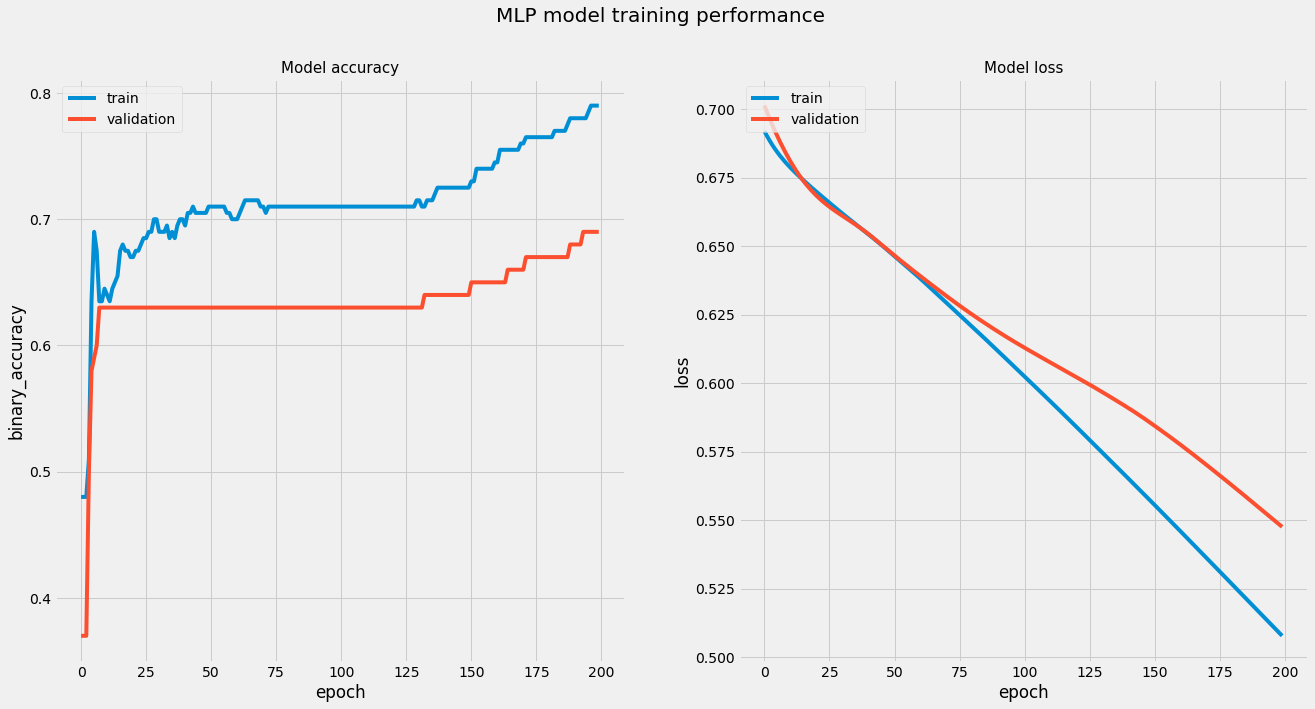

In [53]:
# MLP
fig, axs = plt.subplots(1,2)
fig.suptitle('MLP model training performance', fontsize=20)
axs[0].plot(history_MLP.history['binary_accuracy'])
axs[0].plot(history_MLP.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_MLP.history['loss'])
axs[1].plot(history_MLP.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

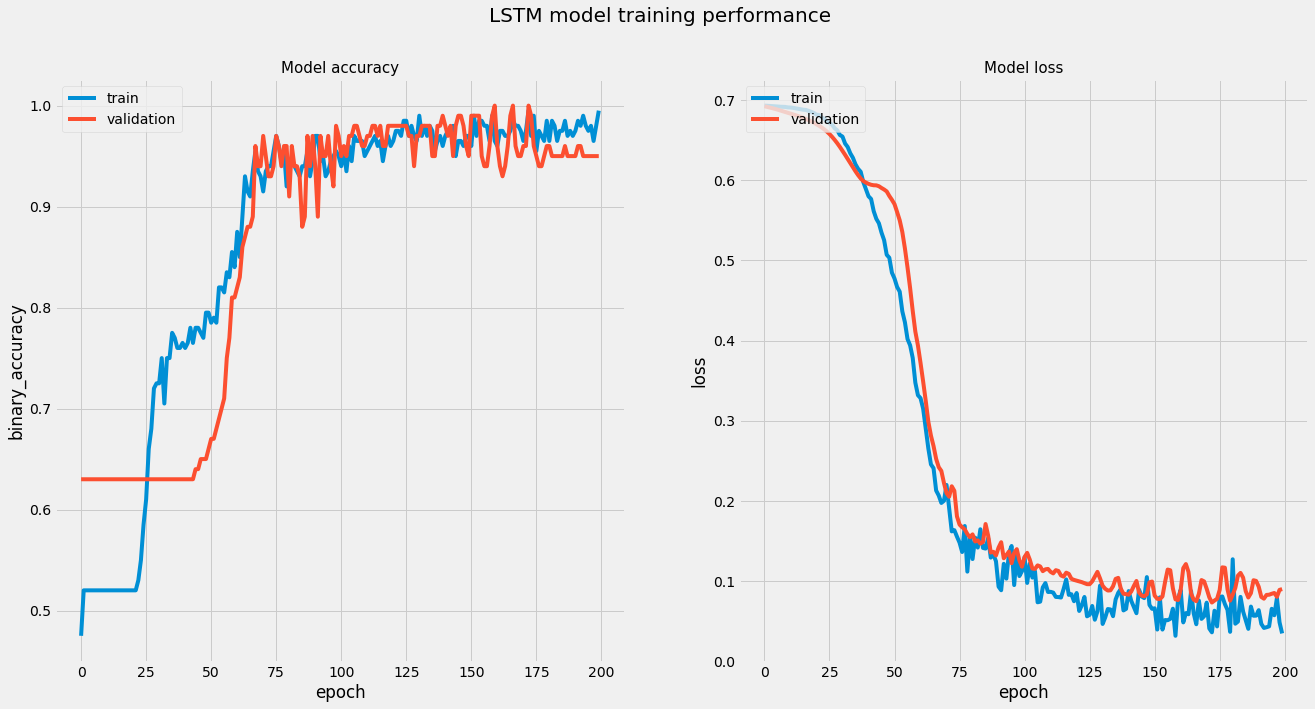

In [54]:
# LSTM
fig, axs = plt.subplots(1,2)
fig.suptitle('LSTM model training performance', fontsize=20)
axs[0].plot(history_LSTM.history['binary_accuracy'])
axs[0].plot(history_LSTM.history['val_binary_accuracy'])
axs[0].set_title('Model accuracy', fontsize=15)
axs[0].set_ylabel('binary_accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')
axs[1].plot(history_LSTM.history['loss'])
axs[1].plot(history_LSTM.history['val_loss'])
axs[1].set_title('Model loss', fontsize=15)
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.show()

### Predicción
Ahora que tenemos el modelo entrenado, necesitamos testearlo en el test set. Usaremos la raiz del error cuadrático medio (RMSE), que es una métrica de error frecuentemente utilizada para medir la diferencia entre los valores reales observados y los predichos por el modelo.

In [55]:
# MLP
y_pred_proba_MLP=MLP.predict_proba(X_test, batch_size=1)
# LSTM
y_pred_proba_LSTM=model_LSTM.predict_proba(X_test_LSTM, batch_size=1)

#### Métricas de predicción en el test set

In [56]:
# MLP
results_MLP=MLP.evaluate(X_test, y_test)
print('MLP: [binary_crossentropy, binary_accuracy] =', results_MLP)

22/22 [==============================] - 0s 877us/step - loss: 0.8101 - binary_accuracy: 0.5000
MLP: [binary_crossentropy, binary_accuracy] = [0.8101096749305725, 0.5]


In [57]:
# LSTM
results_LSTM=model_LSTM.evaluate(X_test_LSTM, y_test)
print('LSTM: [binary_crossentropy, binary_accuracy] =', results_LSTM)

22/22 [==============================] - 0s 4ms/step - loss: 0.4241 - binary_accuracy: 0.8868
LSTM: [binary_crossentropy, binary_accuracy] = [0.42409223318099976, 0.8868194818496704]


#### Curvas ROC

Una curva característica de funcionamiento del receptor (curva ROC) es un diagrama gráfico que ilustra la capacidad de diagnóstico de un sistema clasificador binario a medida que varía su umbral de discriminación.

La curva ROC es creada graficando el ratio true positive (TPR) contra el ratio false positive (FPR) en varios umbrales de ajuste. En machine learning el TPR es también conocido como sensitividad, recall o probabilidada de detección. El FPR es conocido como la probabilidad de una falsa alarma y es calculado como (1 - especificidad).

Esta curva puede pensarse también como el gráfico del poder (power) como función del error tipo 1 de una regla de decisión. La curva ROC es entonces la sensitividad o recall como función del fall-out. 

El análisis de esta curva provee una herramienta para la selección del modelo óptimo sobre subóptimos independientemente la noción de costo que estemos manejando y la distribución de la variable respuesta.

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.708


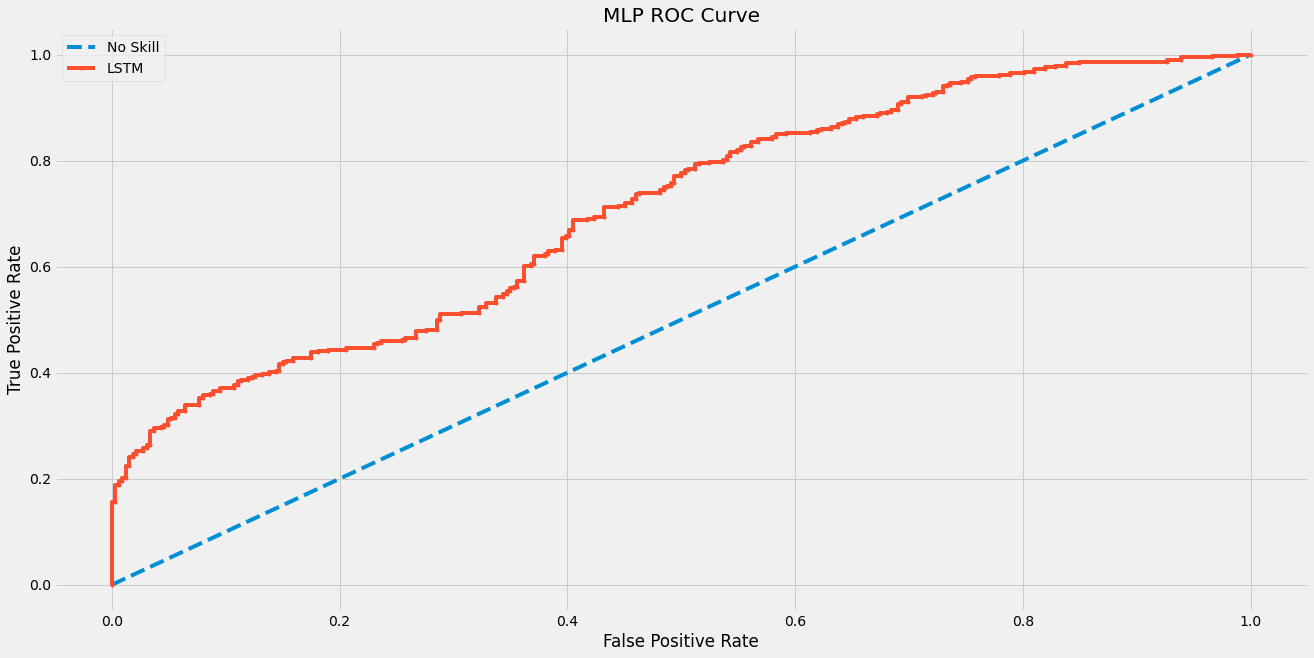

In [58]:
# MLP
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_MLP
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('MLP ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.983


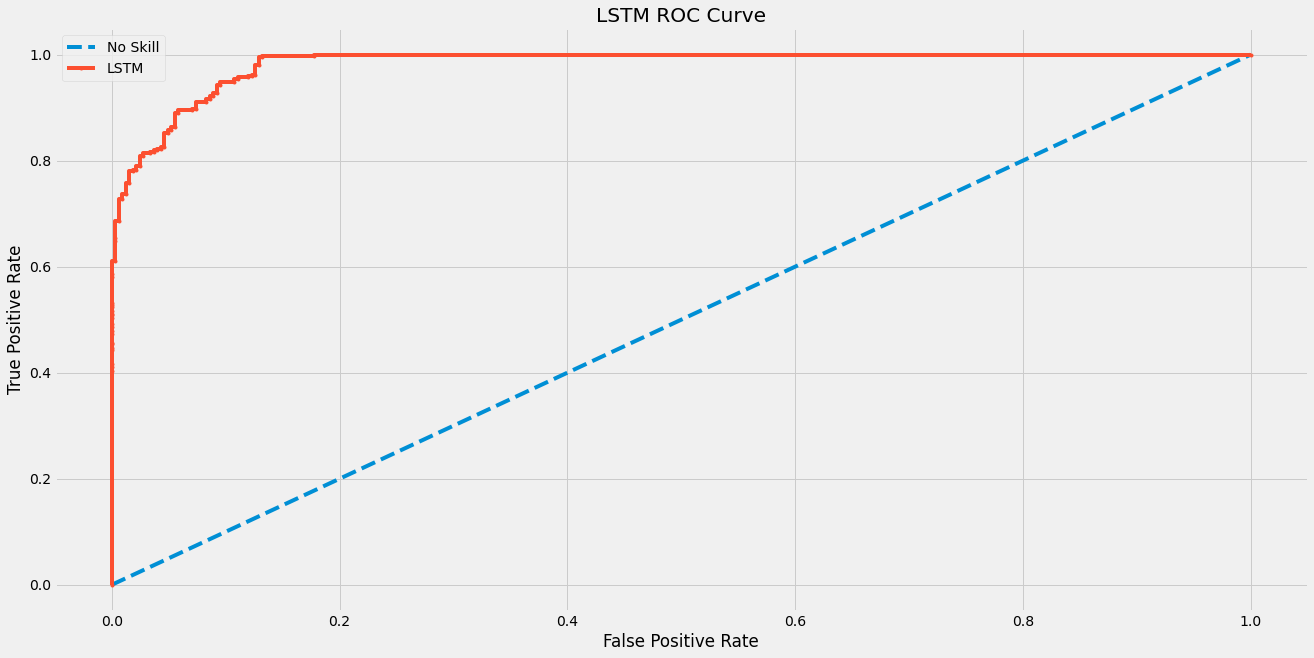

In [59]:
# LSTM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_probs = y_pred_proba_LSTM
#lr_probs = model.predict_proba(X_train)
ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
plt.title('LSTM ROC Curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('ROC.png')
plt.show()

### Summary
We now trained 10 different machine learning algorithms on the same dataset to solve the same task, predicting a positive or negative review based on a sentiment analysis of text passages. So let’s see who wins in terms of the quality of the prediction and in run time. The parameter overfitting (OF) is just the difference from train score to test score. If it is large, it means we have high overfitting. COMPLETAR CON LA TABLA

#### Best Runtime:
In terms of Runtime, the fastest algorithms are Naive Bayes, Support Vector Machine, Voting Classifier and the Neural Network.

#### Best Prediction Score:
In terms of the best prediction of the test dataset, the best algorithms are Logistic Regression, Voting Classifier and Neural Network.

#### Worst Overfitting:
The algorithms that are overfitting the most are Logistic Regression, K-Nearest Neighbours, Decision Tree and Bagging Decision Tree.

#### Best Algorithm:
The overall best approach to solve this text sentiment analysis task is the Neural Network, which is fast, has high accuracy and low overfitting. A little bit faster but a bit worse in prediction quality is the Voting Classifier.

#### Predicción vs Realidad
TERMINAR Y ARREGLAR EL ALGO

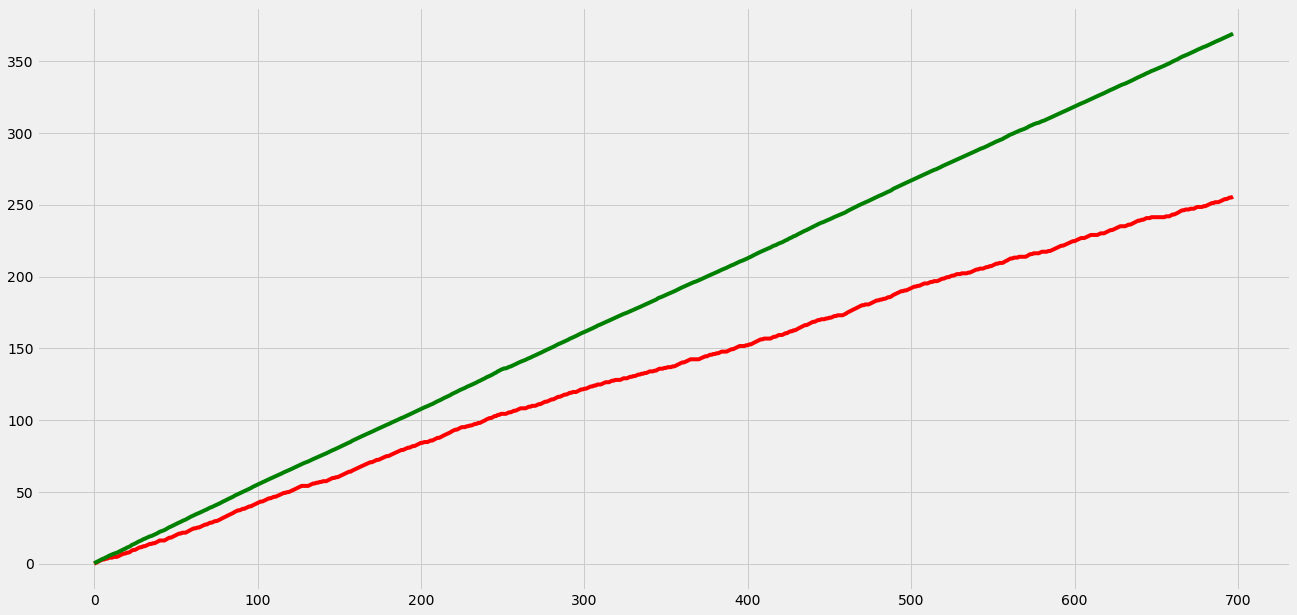

In [60]:
# Plot pred vs actual
# LSTM
C=[]
for b in y_pred_proba_LSTM:
  if(b[0]>=0.5):
    C.append(1)
  else:
    C.append(0)
daily_returns = X[:len(X_test_LSTM)]['Returns']
strategy = daily_returns * C
# Plot the cumulative daily returns (pred vs actual) 
strategy.cumsum().plot(color='red')
daily_returns.cumsum().plot(color='green')
plt.show()